<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (WIP) 06. PyTorch Transfer Learning

**Goal of this section:** Is there a model that already exists for our problem?

* TK - What is transfer learning?
* TK - Why use transfer learning?
* TK - What we're going to cover
* TK - Where can you get help?

## TK - 0. Getting setup

TK - downloading the modules and files needed for this section 

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# TK - explain this
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## TK 1. Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [4]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## TK 2. Create Datasets and DataLoaders

In [5]:
# TK - what is happening here? with normalize layer - see PyTorch docs for "transforms"
# TK - Load in data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
  test_dir=test_dir,
  transform=simple_transform,
  batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe4e288c3d0>,
 ['pizza', 'steak', 'sushi'])

## TK 3. Making a model

In [6]:
# Setup the model
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Print a summary
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                                 --                        --                        --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─ConvNormActivation (0)                                [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [7]:
# TK - view the model
len(list(iter(model.parameters())))
# model.state_dict()

213

### TK - Freeze the base model

In [8]:
# TK - Update the classifier - how is this done?
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)
model.classifier = torch.nn.Linear(1280, output_shape).to(device)

# Freeze all base layers (the feature extractor in EfficientNet)
for param in model.features.parameters():
    param.requires_grad = False

# Print a summary
# model

* TK image - before and after model frozen, show the summary + the change in the different layer shapes + outputs

In [9]:
# TK - do a summary *after* freezing the layers
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                                 --                        --                        --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─ConvNormActivation (0)                                [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

## TK 4. Train model

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0906 | train_acc: 0.4062 | test_loss: 0.9001 | test_acc: 0.5388
Epoch: 2 | train_loss: 0.8596 | train_acc: 0.8047 | test_loss: 0.7819 | test_acc: 0.7841
Epoch: 3 | train_loss: 0.7651 | train_acc: 0.8125 | test_loss: 0.7106 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.7062 | train_acc: 0.7695 | test_loss: 0.6235 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.6237 | train_acc: 0.8008 | test_loss: 0.6045 | test_acc: 0.8864
[INFO] Total training time: 5.147 seconds


## 5. TK - Evaluate model

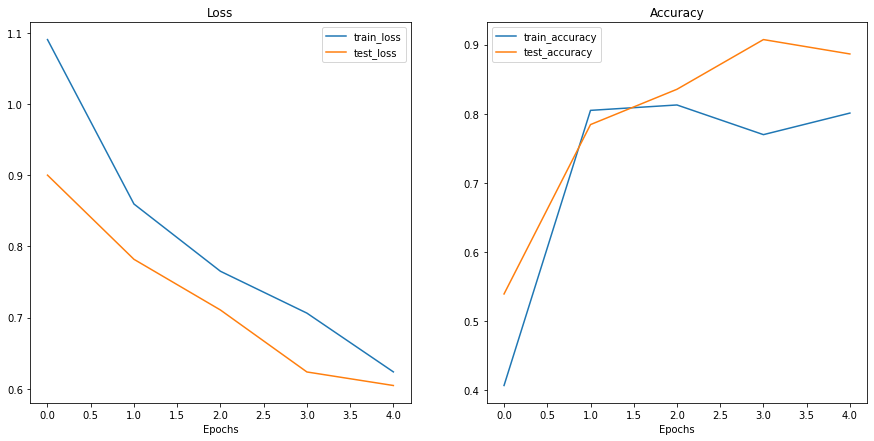

In [12]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

plot_loss_curves(results)

## TK - Make predictions with custom images (could use/create `predict.py` from previous section)

* TK - Things to remember: image has to be in *same* format model was trained on... e.g. same transforms

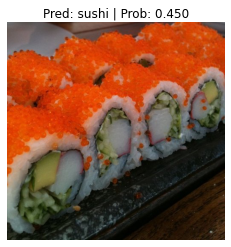

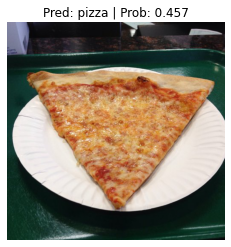

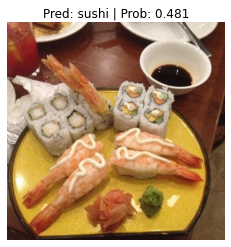

In [13]:
# Get a random image path from test set
import random
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=3)

# Open image
from PIL import Image
from typing import List, Tuple

def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str], 
                        image_size: Tuple[int, int]=(224, 224)):
    # TK - similar to function from notebook 04
    # See here for reference: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
    # Open image
    img = Image.open(image_path)

    # Create transformation for image
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])

    simple_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    normalize,
    ])

    ### Predict on image

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = simple_transform(img).unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names, 
                        image_size=(224, 224))

### TK - Pred on custom image (pizza dad)

data/04-pizza-dad.jpeg already exists, skipping download.


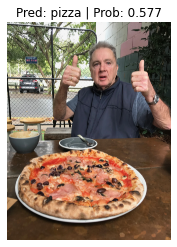

In [14]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

## TK - Extensions + Exercises
* Try a different model from PyTorch pretrained models
  * You'll have to change the size of the classifier layer
  * See here for more models: https://pytorch.org/vision/stable/models.html
  * Try ConvNext-Tiny, does it perform better than EfficientNetB0?
    * `torchvision.models.convnext_tiny()` 
* Train for longer, what happens?
* Train with more data, what happens?
  * Double the images of pizza, steak, sushi
  * Now introduce 10 classes (10 whole foods), see what happens
* Could you add in some data augmentation, what happens?
* Predict on your own image of pizza/steak/sushi - how does the model go?

## TK - Extra-curriculum
* TK - Fine-tuning: if you have lots of data, this may be a good option...
* Check out the PyTorch multi-weights API (still in beta at time of writing, May 2022) - https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/